# Gradient Descent
### A from-stratch implementation in Julia

I thought I understood backprop. I had read a number of explanations and had no trouble following the math or the code examples. Besides, it's just the chain rule, right?

Then I tried to implement backprop myself from the chain rule equations and all of I sudden I had no idea what I was doing and my code would either behave strangely or not work at all due to incompatibly shaped matrices. 

It turns out that a lot of explanations out there of the math behind backprop seem precise but are actually pretty vaguely connected to 1) the network they are operating over and 2) the actual code. So I started this series of notebooks to explain to myself how to implement backprop at increasing levels of complexity, being as explicit as possible about how the math connects to the code. Julia was a natural choice for this, as it has built in support for TeX characters like $\partial$, $\nabla$, etc. which come up often.

We'll start with the simplest network I could think of: 2 input nodes connected directly to a single output node, no hidden layers, no bias, and a linearly separable problem.

# A very basic backprop

Backpropagation is often discussed in the context of *deep* neural networks, but it works just fine for linear models too, so let's start there. To do this, we'll need a linearly separable problem.

$X = \begin{pmatrix} 1 & 3 \\ 2 & 3 \\ 2 & 1 \\ 1 & 1 \end{pmatrix}$

$y = \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0 \end{pmatrix}$

In [1]:
X = [1 3; 2 3; 2 1; 1 1]
y = [1, 1, 0, 0]
println(X)
println(y)

[1 3; 2 3; 2 1; 1 1]
[1, 1, 0, 0]


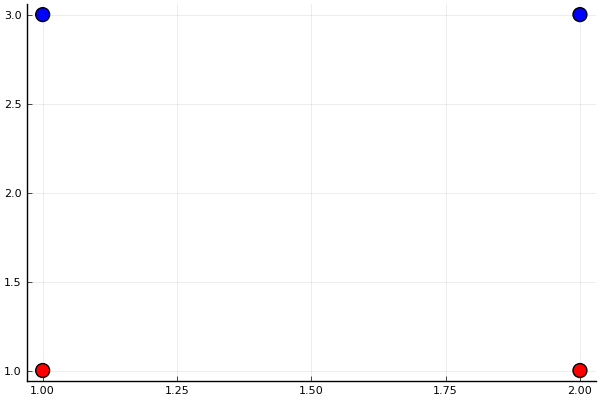

In [2]:
using Plots; pyplot()
scatter(X[:, 1], X[:, 2], color=[:blue, :blue, :red, :red], markersize=10, legend=false)

Immediately, we can see that it is possible to separate the blue from the red points by drawing a horizontal decision boundary at around $y=2$. Below, we'll define a linear model and use backprop to estimate this decision boundary.

## Defining the model

We'll define a linear model with two input nodes (one for each column, or *feature*, in $X$) and one output node using sigmoid activation, which is standard fare for binary prediction models. Such models generally include a bias term as well, but we'll leave it out for now to keep things simple.

Let's write out the equations for this network here.

$o = \sigma(XW)$  the model's predictions

where

$X \in \mathbb{R}^{4 \times 2}$ the input data

$W \in \mathbb{R}^{2 \times 1}$ the weights

$\sigma(z)= \frac{1}{1 + e^{-z}}$  the sigmoid activation function

Below, we initialze $W$ to some starting values and define a function for computing the sigmoid.

In [3]:
W = [0.1, 0.2]

function σ(z)
    # Sigmoid activation function
    return @. 1 / (1 + exp(-z))
end

σ (generic function with 1 method)

## The forward pass

Now, let's compute our model's predictions $o$ by stepping through the equations above. Given our initialized $W$

$W = \begin{pmatrix} 0.1 \\ 0.2 \end{pmatrix}$

the weighted inputs, $z$, are computed

$z = XW = \begin{pmatrix} 1 & 3 \\ 2 & 3 \\ 2 & 1 \\ 1 & 1 \end{pmatrix} \begin{pmatrix} 0.1 \\ 0.2 \end{pmatrix} = \begin{pmatrix} 0.7 \\ 0.8 \\ 0.4 \\ 0.3 \end{pmatrix}$

Applying the sigmoid to these values we get

$o = \sigma(z) = \begin{pmatrix} 0.67 \\ 0.69 \\ 0.60 \\ 0.57 \end{pmatrix}$

In [4]:
z = X * W
println("z: $z")
o = σ(z)
println("o: $o")

z: [0.7000000000000001, 0.8, 0.4, 0.30000000000000004]
o: [0.6681877721681662, 0.6899744811276125, 0.598687660112452, 0.574442516811659]


### Evaluation

The model outputs real-valued scores, so we'll need a decision function to transform these into discrete binary values. Our decision function will assign a 1 to values in $o \ge 0.5$ and a 0 otherwise.

$\hat{y} = \begin{cases}
    1, & \text{if}~~~ o \ge 0.5 \\
    0, & \text{otherwise}
\end{cases}$

We can then use these decisions to compute the model's accuracy against the gold-standard labels $y$.

In [5]:
function decision(o)
    return Int.(o .>= 0.5)
end

function accuracy(y, y_hat)
    N = size(y, 1)
    return sum(y .== y_hat) / N
end

y_hat = decision(o)
acc = accuracy(y, y_hat)

println("̂y: $(y_hat)")
println("y: $(y)")
println("accuracy: $(acc)")

̂y: [1, 1, 1, 1]
y: [1, 1, 0, 0]
accuracy: 0.5


Not very good, but we haven't started training yet!

### Loss

In order to train with backprop, we'll need a way to compute the total loss of our model's real-valued predictions $o$ with respect to the gold-standard labels $y$. Since this is a binary classification problem, we can use binary cross-entropy loss.

$C = -\frac{1}{N} \sum_{i=1}^{N} y_i \times ln(o_i) + (1 - y_i) \times ln(1 - o_i)$

Where $N$ is the number of examples in $X$ (4 in our case), $y_i$ and $o_i$ are the true and predicted labels for example $i$, respectively. 

$C = \frac{-1}{4} \times \begin{pmatrix}
    1 \times ln(0.67) + (1 - 1) \times ln(1 - 0.67) ~ + \\
    1 \times ln(0.69) + (1 - 1) \times ln(1 - 0.69) ~ + \\
    0 \times ln(0.60) + (1 - 0) \times ln(1 - 0.60) ~ + \\
    0 \times ln(0.57) + (1 - 0) \times ln(1 - 0.57) ~~~~
\end{pmatrix}
=
\frac{-1}{4} \times \begin{pmatrix}
    -0.40 ~ + \\
    -0.37 ~ + \\
    -0.92 ~ + \\
    -0.84 ~~~~
\end{pmatrix}
= \frac{2.54}{4} = 0.635
$

A function for computing the binary cross-entropy loss is below.

In [6]:
function clip(a, lo=1e-15, hi=1 - 1e-15)
    if a < lo
        return lo
    elseif a > hi
        return hi
    else
        return a
    end
end

function binary_crossentropy(y, o)
    N = size(y, 1)
    # We "clip" the predicted values to avoid
    # domain errors in the log() function if our
    # model happens to predict 0.0, and to prevent
    # log returning 0.0 if the model predicts 1.0
    o = clip.(o)
    ces = @. (y * log(o)) + ((1-y) * log(1-o))
    return (-1/N) * sum(ces)
end

loss = binary_crossentropy(y, o)
println("Loss: $(loss)")

Loss: 0.6354143029254289


## Derivatives for the backward pass

The goal of the backward pass is to compute the updates for the model weights $W$. We do this by propagating the loss backwards through the model, from the loss $C$ to $W$. In other words, we want to know how the loss changes when we change each of the weights $w_i \in W$. This means we need to take the partial derivative of the loss with respect to each of the weights. Since the value of our loss function $C$ is not a direct function of $W$, but rather an indirect function of $W$ via $o = \sigma(z), z = XW$, we need the chain rule.

$$ \frac{\partial{C}}{\partial{W}} = \frac{\partial{C}}{\partial{o}} \frac{d{o}}{d{z}} \frac{\partial{z}}{\partial{W}} $$

## 1. $\frac{\partial{C}}{\partial{o}}$
Let's first compute the partial derivative of the cost with respect to the network output, $\frac{\partial{C}}{\partial{o}}$. We saw above that 

$$ C = -\frac{1}{N} \sum_{i=1}^{N} y_i \times ln(o_i) + (1 - y_i) \times ln(1 - o_i) $$

We'll make this a little nicer to look at by working with only a single input example first.

$$ C = - \left[ y \times ln(o) + (1 - y) \times ln(1 - o) \right] $$
$$ \frac{\partial C}{\partial o} = - \frac{\partial}{\partial o} \left[ y \times ln(o) + (1 - y) \times ln(1 - o) \right] $$

We can further simplify things by splitting up the derivatives and distributing the $-$.

$$ \frac{\partial C}{\partial o} = - \left[ \frac{\partial}{\partial o} y \times ln(o) \right] - \left[ \frac{\partial}{\partial o} (1 - y) \times ln(1 - o) \right]$$

The first term is
$$ \frac{\partial}{\partial o} y \times ln(o) = \frac{y}{o} $$

The second term is
$$ \frac{\partial}{\partial o} (1 - y) \times ln(1 - o) = - \frac{1-y}{1-o} $$

Therefore,

$$ \frac{\partial C}{\partial o} = - \frac{y}{o} + \frac{1-y}{1-o} = \frac{o - y}{o(1-o)} $$

<br>

We derived this by looking at a single input example, but we can "vectorize" this last equation by simply treating the subtractions as element-wise over input examples, so the value of $\frac{\partial C}{\partial o}$ will be a vector in $\mathbb{R}^N$.

## 2. $\frac{d{o}}{d{z}} = \frac{d{\sigma}}{d{z}}$
Next up is the derivative of the output $o$ with respect to the weighted input $z$, which is really just the derivative of the sigmoid function $\sigma$.

$$ o = \sigma(z) = \frac{1}{1 + e^{-z}} $$

By applying the quotient rule you should get

<br>

$$ \frac{d\sigma}{dz} = \frac{e^{-z}}{(1+e^{-z})^2} $$

<br>

But we can simplify this further using some tricky algebra. First, splitting the square into a product we get

$$ \frac{d\sigma}{dz} = \frac{1}{1+e^{-z}} \frac{e^{-z}}{1+e^{-z}} = \sigma(z) \frac{e^{-z}}{1+e^{-z}}$$

Now the fun bit.

$$
\begin{align}
\frac{d\sigma}{dz} &= \sigma(z) \frac{e^{-z}}{1+e^{-z}} \\
                   &= \sigma(z) \frac{(1+e^{-z}) -1}{1+e^{-z}} \\
                   &= \sigma(z) \left( \frac{1+e^{-z}}{1+e^{-z}} - \frac{1}{1+e^{-z}}\right) \\
                   &= \sigma(z) (1 - \sigma(z))
\end{align}
$$


## 3. $ \frac{\partial{z}}{\partial{W}} $

This one's easy. Since $z = XW$, 

$$ \frac{\partial{z}}{\partial{W}} = X $$

## The Backward Pass

Let's actually compute these then.

$\frac{\partial{C}}{\partial{o}} = \frac{o - y}{o(1-o)} =
    \begin{pmatrix} \frac{0.67 - 1}{0.67(1-0.67)} \\ 
                    \frac{0.69 - 1}{0.69(1-0.69)} \\
                    \frac{0.60 - 0}{0.60(1-0.60)} \\ 
                    \frac{0.57 - 0}{0.57(1-0.57)} 
    \end{pmatrix}
    = 
    \begin{pmatrix} -1.50 \\ -1.45 \\ 2.49 \\ 2.35 \end{pmatrix}
$

$\frac{d{o}}{d{z}} = \frac{d{\sigma}}{d{z}} = \sigma(z)(1-\sigma(z)) =
    \begin{pmatrix} 
        0.67(1-0.67) \\ 0.69(1-0.69) \\ 0.60(1-0.60) \\ 0.57(1-0.57) 
    \end{pmatrix}
    =
    \begin{pmatrix} 0.22 \\ 0.21 \\ 0.24 \\ 0.24 \end{pmatrix}
$

$\frac{\partial{z}}{\partial{W}} = X = \begin{pmatrix} 1 & 3 \\ 2 & 3 \\ 2 & 1 \\ 1 & 1 \end{pmatrix}$

In [7]:
function ∂C_∂o(y, o)
    num = o .- y
    denom = o .* (1 .- o)
    return num ./ denom
end

function dσ_dz(z)
    o = σ(z)
    return @. o * (1.0 - o)
end

println("∂C_∂o: $(∂C_∂o(y, o))")
println("dσ_dz: $(dσ_dz(z))")
println("∂z_∂W = X = $(X)")

∂C_∂o: [-1.4965853037914094, -1.4493289641172216, 2.4918246976412703, 2.349858807576003]
dσ_dz: [0.22171287329310904, 0.2139096965202944, 0.24026074574152914, 0.24445831169074586]
∂z_∂W = X = [1 3; 2 3; 2 1; 1 1]


Now the actual computation of $\frac{\partial{C}}{\partial{W}} = \frac{\partial{C}}{\partial{o}} \frac{do}{dz} \frac{\partial{z}}{\partial{W}}$ can get a little tricky if we're not careful, so let's be more obvious with our notation.

$\frac{\partial{C}}{\partial{W}} = \Big ( \frac{\partial{C}}{\partial{o}} \odot \frac{do}{dz} \Big )^T X$

where $\odot$ is elementwise multiplication, otherwise known as the *Hadamard product*.

Looking at the shapes of what we're multiplying together also helps.

$\Big ( \mathbb{R}^{4 \times 1} \odot \mathbb{R}^{4 \times 1} \Big ) = \mathbb{R}^{4 \times 1}$

${\mathbb{R}^{4 \times 1}}^T \mathbb{R}^{4 \times 2} = \mathbb{R}^{1 \times 2}$

This *almost* checks out with what we expect. Remember that the result of this operation should tell us how to update $W$, but $W \in \mathbb{R}^{2 \times 1}$, so we'll need to transpose one or the other in order to get them in the same orientation.

$\Big ( \frac{\partial{C}}{\partial{o}} \odot \frac{do}{dz} \Big )^T = \Big ( 
    \begin{pmatrix} -1.50 \\ -1.45 \\ 2.49 \\ 2.35 \end{pmatrix}
        \odot
    \begin{pmatrix} 0.22 \\ 0.21 \\ 0.24 \\ 0.24 \end{pmatrix} \Big )^T
    =
    \begin{pmatrix} -0.33 & -0.30 & 0.60 & 0.56 \end{pmatrix}
$

$\frac{\partial{C}}{\partial{W}} = \Big ( \frac{\partial{C}}{\partial{o}} \odot \frac{do}{dz} \Big )^T X = 
    \begin{pmatrix} -0.33 & -0.30 & 0.60 & 0.56 \end{pmatrix}
    \begin{pmatrix} 1 & 3 \\ 2 & 3 \\ 2 & 1 \\ 1 & 1 \end{pmatrix}
    =
    \begin{pmatrix} 0.82 & -0.75 \end{pmatrix}
$

In [8]:
∂C_∂W = transpose(∂C_∂o(y, o) .* dσ_dz(z)) * X

1×2 LinearAlgebra.Transpose{Float64,Array{Float64,1}}:
 0.819955  -0.752383

## Weight updates

Since our binary cross entropy error function is 2 dimensional, we can plot it, with $y$ (the gold standard) and $o$ (the predicted scores) on the xy-plane and the value of the function on the z-axis.


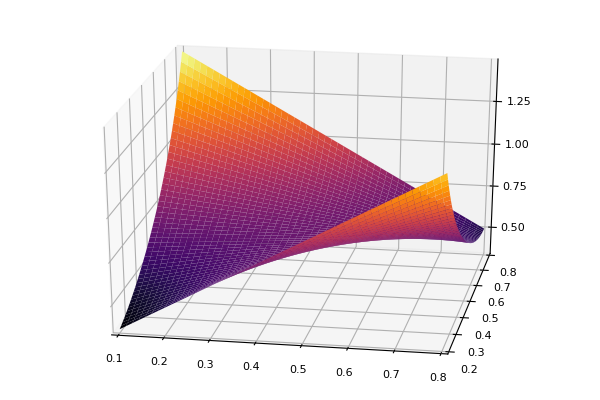

In [9]:
using Distributions

a = range(0.1, stop=0.8, length=50)
b = range(0.2, stop=0.8, length=50)
f(a, b) = binary_crossentropy.(a, b)
plot(a, b, f, st=:surface, cbar=false, seriesalpha=0, camera=(10,25))

If you're familiar with gradients from calculus, you may already know that $\frac{\partial{C}}{\partial{W}}$ is a vector that points in the direction of *maximum increase* of the error function $C$ with respect to $W$. 

<br>

Thinking about this with respect to the image above, the gradient of our initial guess will point *up* the slope, towards the yellow. Therefore, to minimize the error and go *down* the slope towards the purple, we'll want to move opposite the gradient (i.e. $-\frac{\partial{C}}{\partial{W}}$).

This insight leads to our first attempt at an update equation for $W$

$W^{(t+1)} \leftarrow W^{(t)} - \frac{\partial{C}}{\partial{W}}$

where $W^{(t)}$ represents the weight vector at training step $t$.

Iteratively computing the error of our model and then computing the weight updates given the error is the essence of gradient descent. Let's put this all together in a simple `for` loop to get started. 

In [10]:
W_t = copy(W)
for t=1:10
    # Forward pass
    z = X * W_t
    o = σ(z)
    loss = binary_crossentropy(y, o)
    println("Loss at training step $t: $loss")
    # Backward pass and weight update
    ∂C_∂W = transpose(∂C_∂o(y, o) .* dσ_dz(z)) * X
    W_t = W_t .- transpose(∂C_∂W)
end

Loss at training step 1: 0.6354143029254289
Loss at training step 2: 0.4058656742028299
Loss at training step 3: 0.41868591352928425
Loss at training step 4: 1.0067750278046674
Loss at training step 5: 0.9049607854375845
Loss at training step 6: 1.811648377225643
Loss at training step 7: 0.1410851517809659
Loss at training step 8: 0.13829190891212276
Loss at training step 9: 0.13561251612794425
Loss at training step 10: 0.13306864098930912


### Debugging

What's wrong here? The learning rate initially decreases from step 1 to 2, but then oscillates a few times before settling down. If the negative gradient points towards the minimum of the loss function, why would the loss increase? 

It turns out that if the magnitude of the gradient is too large, it will overshoot the minimum and shoot up the other side. A too-large gradient can be cause by (primarily) two things:

 1. The computation of $\frac{\partial C}{\partial W}$ accumulates the gradient of all the input examples. Therefore, the magnitude will increase as the number of training examples increases. 
 
 2. The error surface changes rapidly around the current point. For example, perhaps the slope of the error surface is steep at the current point, levels off suddenly just below it at a local minimum, and then increases steeply again just past the minimum.
 
In both cases, simply subtracting the gradient vector from the weights could move the model parameters too far, entirely skipping over a minima, and can even result in gradient descent getting stuck oscillating between two non-optimal points.

<br>

### The Learning Rate $\eta$

To combat this, we can scale the gradient by a parameter $\eta \in \mathbb{R}$, commonly called the *learning rate*, as it's magnitude determines how slowly or quickly gradient descent travels across the error surface. Our new update is then,

$W^{(t+1)} \leftarrow W^{(t)} - \eta \frac{\partial{C}}{\partial{W}}$

In practice, $\eta$ is often set in the range $[1e^{-5}, 1e^{-1}]$. Here we'll use $\eta = 0.5$ just to get things moving on this toy problem.

In [11]:
η = 0.5
W_t = copy(W)
for t=1:10
    z = X * W_t
    o = σ(z)
    loss = binary_crossentropy(y, o)
    println("Loss at training step $t: $loss")
    ∂C_∂W = transpose(∂C_∂o(y, o) .* dσ_dz(z)) * X
    # Scale the gradient by the learning rate.
    W_t = W_t .- (η .* transpose(∂C_∂W))
end

Loss at training step 1: 0.6354143029254289
Loss at training step 2: 0.5021368690276575
Loss at training step 3: 0.42489287091790723
Loss at training step 4: 0.38001125080664333
Loss at training step 5: 0.3484655288292048
Loss at training step 6: 0.33106153286204654
Loss at training step 7: 0.29877480501381526
Loss at training step 8: 0.2826410701985972
Loss at training step 9: 0.2593564746815564
Loss at training step 10: 0.2467018688501049


That looks better! Let's run it for more iterations to see where it ends up.

In [12]:
η = 0.5
W_t = copy(W)
for t=1:50
    z = X * W_t
    o = σ(z)
    if t == 1 || t % 5 == 0
        loss = binary_crossentropy(y, o)
        acc = accuracy(y, decision(o))
        println("Training step $t: Loss: $loss, Accuracy: $acc")
    end
    ∂C_∂W = transpose(∂C_∂o(y, o) .* dσ_dz(z)) * X
    W_t = W_t .- (η .* transpose(∂C_∂W))
end

Training step 1: Loss: 0.6354143029254289, Accuracy: 0.5
Training step 5: Loss: 0.3484655288292048, Accuracy: 1.0
Training step 10: Loss: 0.2467018688501049, Accuracy: 1.0
Training step 15: Loss: 0.20842413699493623, Accuracy: 1.0
Training step 20: Loss: 0.18733695410574, Accuracy: 1.0
Training step 25: Loss: 0.17237567448371208, Accuracy: 1.0
Training step 30: Loss: 0.16079325562841384, Accuracy: 1.0
Training step 35: Loss: 0.15132582953245927, Accuracy: 1.0
Training step 40: Loss: 0.14330143874177748, Accuracy: 1.0
Training step 45: Loss: 0.13632537461110222, Accuracy: 1.0
Training step 50: Loss: 0.13014797436551886, Accuracy: 1.0


I'd call that solved!

---

<br>

## A non-linear problem

So we've defined a linear model (i.e. a model with no hidden layers) to solve a very straightforward classification task. But what if our task isn't linearly separable? Let's take the *exclusive or (XOR)* function, for example. 

$XOR(a, b) = \begin{cases}
    1, & \text{if}~~~ a \neq b \\
    0, & \text{otherwise}
\end{cases}$

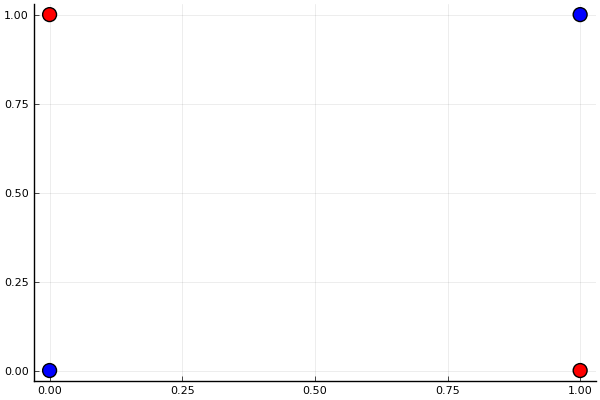

In [13]:
X = [0 0; 1 1; 0 1; 1 0]
y = [0, 0, 1, 1]
using Plots; pyplot()
scatter(X[:, 1], X[:, 2], color=[:blue, :blue, :red, :red], markersize=10, legend=false)

There's no way to draw a line that perfectly separates the blue points from the red points, so we can be pretty sure that our linear model isn't going to do well here. 

Let's try it anyway, just to see what happens.

In [14]:
η = 1
W_t = copy(W)
for t=1:100
    # Forward pass
    z = X * W_t
    o = σ(z)
    if t == 1 || t % 10 == 0
        loss = binary_crossentropy(y, o)
        acc = accuracy(y, decision(o))
        println("Training step $t: Loss: $loss, Accuracy: $acc")
    end
    # Backward pass and weight updates
    ∂C_∂W = transpose(∂C_∂o(y, o) .* dσ_dz(z)) * X
    W_t = W_t .- (η .* transpose(∂C_∂W))
end

Training step 1: Loss: 0.6975094886209088, Accuracy: 0.5
Training step 10: Loss: 0.6931480652512929, Accuracy: 0.25
Training step 20: Loss: 0.6931471833654955, Accuracy: 0.25
Training step 30: Loss: 0.6931471805688423, Accuracy: 0.25
Training step 40: Loss: 0.6931471805599736, Accuracy: 0.25
Training step 50: Loss: 0.6931471805599454, Accuracy: 0.25
Training step 60: Loss: 0.6931471805599453, Accuracy: 0.25
Training step 70: Loss: 0.6931471805599453, Accuracy: 0.25
Training step 80: Loss: 0.6931471805599453, Accuracy: 0.25
Training step 90: Loss: 0.6931471805599453, Accuracy: 0.25
Training step 100: Loss: 0.6931471805599453, Accuracy: 0.25


The loss starts out decreasing (albeit slowly) but then eventually stagnates after training step 50, and accuracy never improves.

In order to solve this problem, we'll have to introduce *nonlinearities* into our model. Recall that a single matrix multiplication is equivalent to a [linear transformation](https://www.freetext.org/Introduction_to_Linear_Algebra/Linear_Transformations/Matrix_Multiplication/), so chaining multiple matrix multiplications together will comrpise a nonlinear transformation. The model we define here is a linear model because it only uses a single matrix multiplication ($XW$), so to make it nonlinear, we can just add another weight matrix, which is equivalent to adding another hidden layer. Backprop generalizes nicely to multiple hidden layers, but we'll need to make some changes to our training loop. See the next notebook for details.